In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vehicular-mobility-trace-at-seoul-sparse/sparse.csv
/kaggle/input/vehicular-mobility-trace-at-seoul-sparse/Readme_sparse.md


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Load your data
df = pd.read_csv('/kaggle/input/vehicular-mobility-trace-at-seoul-sparse/sparse.csv')

Now, we'll load our data. Data is procured from [IEEE Dataport](https://ieee-dataport.org/open-access/vehicular-mobility-trace-seoul-south-korea).

 [\[Reference Paper\]](https://doi.org/10.1109/LCOMM.2020.3032753).

 Our data is time-series based and presents different features of vehicles, such as coordinates, angle, lane, speed, etc.
 Our objective is to predict radio handover of these vehicles in the next time step. We will discuss it further in future.
 
 So, let's evaluate the data a little bit!


In [3]:
# Assuming `df` is your DataFrame

# Find the max and min of 'x'
max_x = df['x'].max()
min_x = df['x'].min()

# Find the row for max and min 'x'
row_max_x = df.loc[df['x'].idxmax()]
row_min_x = df.loc[df['x'].idxmin()]

# Find the max and min of 'y'
max_y = df['y'].max()
min_y = df['y'].min()

# Find the row for max and min 'y'
row_max_y = df.loc[df['y'].idxmax()]
row_min_y = df.loc[df['y'].idxmin()]

# Find the max and min of 'speed'
max_speed = df['speed'].max()
min_speed = df['speed'].min()

# Find the row for max and min 'speed'
row_max_speed = df.loc[df['speed'].idxmax()]
row_min_speed = df.loc[df['speed'].idxmin()]

# Print the results
print(f"Max x: {max_x}\nRow for max x:\n{row_max_x}\n")
print("------------------------------------\n")
print(f"Min x: {min_x}\nRow for min x:\n{row_min_x}\n")
print("------------------------------------\n")
print(f"Max y: {max_y}\nRow for max y:\n{row_max_y}\n")
print("------------------------------------\n")
print(f"Min y: {min_y}\nRow for min y:\n{row_min_y}\n")
print("------------------------------------\n")
print(f"Max speed: {max_speed}\nRow for max speed:\n{row_max_speed}\n")
print("------------------------------------\n")
print(f"Min speed: {min_speed}\nRow for min speed:\n{row_min_speed}\n")
print("------------------------------------\n")

# Find the number of distinct vehicles
num_vehicles = df['id'].nunique()

# Print the number of distinct vehicles
print(f"Number of distinct vehicles: {num_vehicles}")

Max x: 1420.58
Row for max x:
time            2198.0
id             veh2549
x              1420.58
y              1661.63
angle            90.54
type     veh_passenger
speed            17.04
pos             362.49
lane     218919060#1_0
slope              0.0
Name: 428232, dtype: object

------------------------------------

Min x: 2.14
Row for min x:
time             117.0
id              veh141
x                 2.14
y              1666.14
angle            60.79
type     veh_passenger
speed            17.85
pos                5.1
lane     621513156#0_3
slope              0.0
Name: 5684, dtype: object

------------------------------------

Max y: 2212.71
Row for max y:
time             384.0
id              veh389
x               509.39
y              2212.71
angle             0.17
type     veh_passenger
speed            30.96
pos             361.39
lane       616037664_3
slope              0.0
Name: 29667, dtype: object

------------------------------------

Min y: 820.68
Row for min

Now let's visulize the data (where are the vehicles in our 1500*2500m area?)

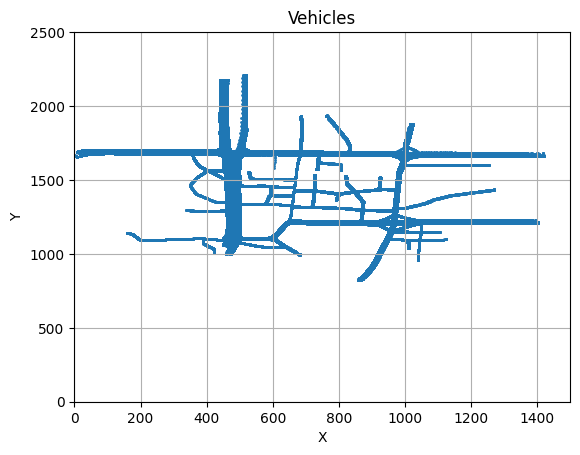

In [4]:
# Create a scatter plot of the vehicles
X_LIM = 1500
Y_LIM = 2500

plt.scatter(df['x'], df['y'], s=1)  # s parameter is used to make the points smaller

plt.xlim(0, X_LIM)
plt.ylim(0, Y_LIM)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Vehicles')
plt.grid(True)
plt.show()

First, we'll define where our base stations (BS) will be. We'll define 20 BSs in the 1500*2500m area of this problem.

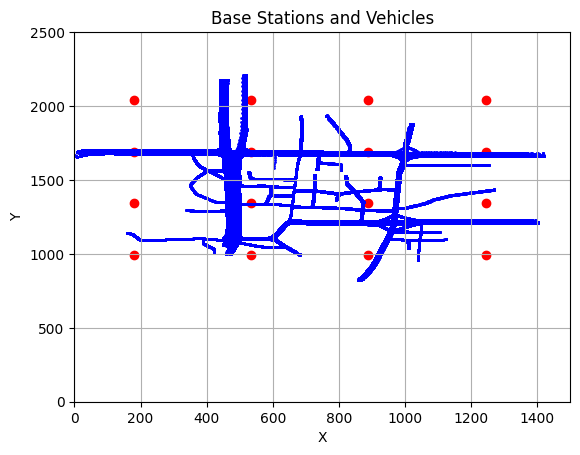

   time    id       x        y  angle           type  speed  pos  \
0   0.0  veh0  501.42  1473.12   0.29  veh_passenger    0.0  5.1   

            lane  slope  
0  378453707#7_0    0.0  


In [5]:
# Define the limits
#X_LIM = 1500
#Y_LIM = 2500
#based on vehicle map
X_MIN, X_MAX = 2.14, 1420.58
Y_MIN, Y_MAX = 820.68, 2212.71

# Define the number of BSs
num_BSs = 20

# Calculate the number of rows and columns in the grid
num_rows = num_cols = int(np.sqrt(num_BSs))

# Calculate the width and height of each cell
cell_width = (X_MAX - X_MIN) / num_cols
cell_height = (Y_MAX - Y_MIN) / num_rows

# Calculate the coordinates of the BSs
BSs = {}
for i in range(num_rows):
    for j in range(num_cols):
        x = X_MIN + j * cell_width + cell_width / 2
        y = Y_MIN + i * cell_height + cell_height / 2
        BSs[f'BS{i*num_cols+j+1}'] = (x, y)

        
# Create a scatter plot of the BSs
for bs, (x, y) in BSs.items():
    plt.scatter(x, y, label=bs, color='red')

# Create a scatter plot of the vehicles
plt.scatter(df['x'], df['y'], s=1, color='blue')  # s parameter is used to make the points smaller

plt.xlim(0, 1500) #plt.xlim(X_MIN, X_MAX)
plt.ylim(0, 2500) #plt.ylim(Y_MIN, Y_MAX)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Base Stations and Vehicles')
plt.grid(True)
plt.show()

# Assuming df is your DataFrame and you want to print the first row
print(df.iloc[[0]])

So, let's define new features.
First, 20 columns will be added, each for one of the BSs, which would have the distance between the user and that BS at that time step.
Then, the feature 'BS' would determine that the user is assigned to which BS (The BS with the lowest distance would be elected)
Afterwards, 'handover' would predict (in binary) that if the user/vehicle is going to change its assigned BS in the next time step or not. In other words, if 'handover'==1, the user will change its 'BS' in the next timestep.

In [6]:
# Calculate the distance of each vehicle from each BS
for bs, (x_bs, y_bs) in BSs.items():
    df[bs] = np.sqrt((df['x'] - x_bs)**2 + (df['y'] - y_bs)**2)

# Determine the BS to which each vehicle is connected
df['BS'] = df[list(BSs.keys())].idxmin(axis=1)

# Create the 'handover' variable
df['handover'] = (df.groupby('id')['BS'].shift(-1) != df['BS']).astype(int)

# Define the features and the target variable
X = df[['x', 'y', 'speed', 'angle']]
y = df['handover']

Now let's split the data and train the model using Linear Regression (which might not be the best algorithm for this purpose)

In [7]:
from sklearn import linear_model
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = linear_model.LogisticRegression(penalty='l2', C=1.0)
model.fit(X_train, y_train)
# Train the model
# model = LinearRegression()
# model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)
model.score(X, y)


0.9895772169733413

In [8]:
# Set the display option to show all columns
pd.set_option('display.max_columns', None)

# Now print the first row
print(df.head(15))


# Print the rows where 'handover' is 1
print(df[df['handover'] == 1])
# Count the rows where 'handover' is 1
count = df[df['handover'] == 1].shape[0]

print(f"Number of rows where 'handover' is 1: {count}")

    time    id        x        y   angle           type  speed    pos  \
0    0.0  veh0   501.42  1473.12    0.29  veh_passenger   0.00   5.10   
1    0.0  veh1   647.08  1333.51  271.18  veh_passenger   0.00   5.10   
2    1.0  veh0   501.43  1475.08    0.29  veh_passenger   1.96   7.06   
3    1.0  veh1   645.29  1333.54  271.18  veh_passenger   1.79   6.89   
4    1.0  veh2   441.56  2179.34  183.12  veh_passenger  28.07   5.10   
5    2.0  veh0   501.37  1479.55  359.34  veh_passenger   4.44   1.77   
6    2.0  veh1   641.53  1333.62  271.18  veh_passenger   3.76  10.65   
7    2.0  veh2   440.55  2152.48  181.17  veh_passenger  26.81  31.91   
8    2.0  veh3   459.32  1339.70  179.38  veh_passenger   0.00   5.10   
9    3.0  veh0   501.11  1485.68  357.64  veh_passenger   6.02   7.80   
10   3.0  veh1   636.05  1333.73  271.18  veh_passenger   5.49  16.14   
11   3.0  veh2   439.99  2124.88  181.17  veh_passenger  27.53  59.44   
12   3.0  veh3   459.34  1337.29  179.38  veh_passe

Check how many handovers we have!

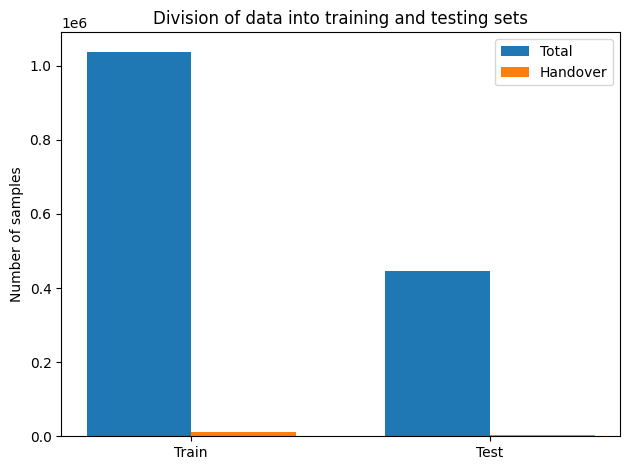

In [9]:
# Assuming `X_train` and `X_test` are your training and testing data

# Calculate the number of samples in each set
#based on # Split the data into training and testing sets X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)

num_train_samples = len(X_train)
num_test_samples = len(X_test)


# Calculate the number of handovers in each set
num_train_handovers = np.sum(y_train)
num_test_handovers = np.sum(y_test)

# Create a bar plot
labels = ['Train', 'Test']
total_samples = [num_train_samples, num_test_samples]
handover_samples = [num_train_handovers, num_test_handovers]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, total_samples, width, label='Total')
rects2 = ax.bar(x + width/2, handover_samples, width, label='Handover')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of samples')
ax.set_title('Division of data into training and testing sets')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

**Data is highly imbalanced as you can see!**


Following 'veh3' when handover==1!

In [10]:
print(df[(df['id'] == 'veh3') & (df['time'] > 30.0) & (df['time'] < 50.0)])

     time    id       x        y   angle           type  speed    pos  \
508  31.0  veh3  389.47  1088.11  185.33  veh_passenger   7.82  10.57   
539  32.0  veh3  388.61  1078.87  185.33  veh_passenger   9.28  19.84   
570  33.0  veh3  391.83  1068.03  146.31  veh_passenger  11.83  31.67   
601  34.0  veh3  400.99  1057.61  137.97  veh_passenger  13.89  45.56   
632  35.0  veh3  410.94  1046.58  137.97  veh_passenger  14.85  60.42   
665  36.0  veh3  420.77  1035.40  139.99  veh_passenger  14.93  75.34   
698  37.0  veh3  422.95  1020.84  179.14  veh_passenger  14.87  90.21   

            lane  slope         BS1         BS2         BS3         BS4  \
508  176728954_0    0.0  229.867277  172.143215  507.862297  858.901299   
539  176728954_0    0.0  225.471333  168.052292  507.092031  858.801250   
570  176728954_0    0.0  224.693259  160.023820  502.219762  854.598304   
601  176728954_0    0.0  230.308272  147.193774  491.718027  844.632307   
632  176728954_0    0.0  237.240713  133

Now let's evaluate how the linear regression works!



In [11]:
from sklearn import metrics

# Make predictions
#predictions = model.predict(X_test)

# Calculate metrics
mae = metrics.mean_absolute_error(y_test, predictions)
mse = metrics.mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse) # or mse**(0.5)
r2 = metrics.r2_score(y_test, predictions)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")
print("\n---------------------------\n")

# Binarize the predictions
predictions_bin = [1 if p > 0.5 else 0 for p in predictions]

# Calculate metrics
confusion_matrix = metrics.confusion_matrix(y_test, predictions_bin)
precision = metrics.precision_score(y_test, predictions_bin)
recall = metrics.recall_score(y_test, predictions_bin)
f1_score = metrics.f1_score(y_test, predictions_bin)
auc_roc = metrics.roc_auc_score(y_test, predictions)

print(f"Confusion Matrix:\n {confusion_matrix}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")
print(f"AUC-ROC: {auc_roc}")

MAE: 0.010494004709943014
MSE: 0.010494004709943014
RMSE: 0.10244024946251847
R2: -0.016203292474368913

---------------------------

Confusion Matrix:
 [[440346     26]
 [  4644      0]]
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
AUC-ROC: 0.49997047950369233


Now let's output the whole dataset for linear regression! clearly we did not achieve our goal here!

In [12]:
# Store the DataFrame to a CSV file
df.to_csv('output_sparse_linear_regression.csv', index=False)